<a href="https://colab.research.google.com/github/NagaSaiRam89/21_daysML/blob/main/Day_4/Day_4_running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score


# Set plot style
sns.set_style('whitegrid')

In [19]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Step 2: Exploratory Data Analysis (EDA)
Before building any models, we need to understand our data deeply. We'll look at the distribution of our target variable, the characteristics of our features, and how they relate to the presence of heart disease.

In [20]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [21]:
df.isna().sum().sort_values(ascending=False)

,0
ca,611
thal,486
slope,309
fbs,90
oldpeak,62
trestbps,59
exang,55
thalch,55
chol,30
restecg,2


#### 2.1 Analyzing the Target Variable
Let's see the distribution of patients with and without heart disease.

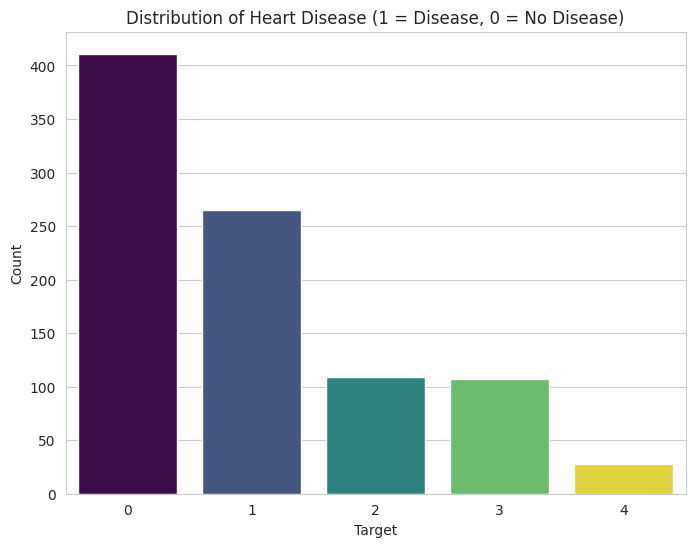

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

#### 2.2 Analyzing Features vs. Target

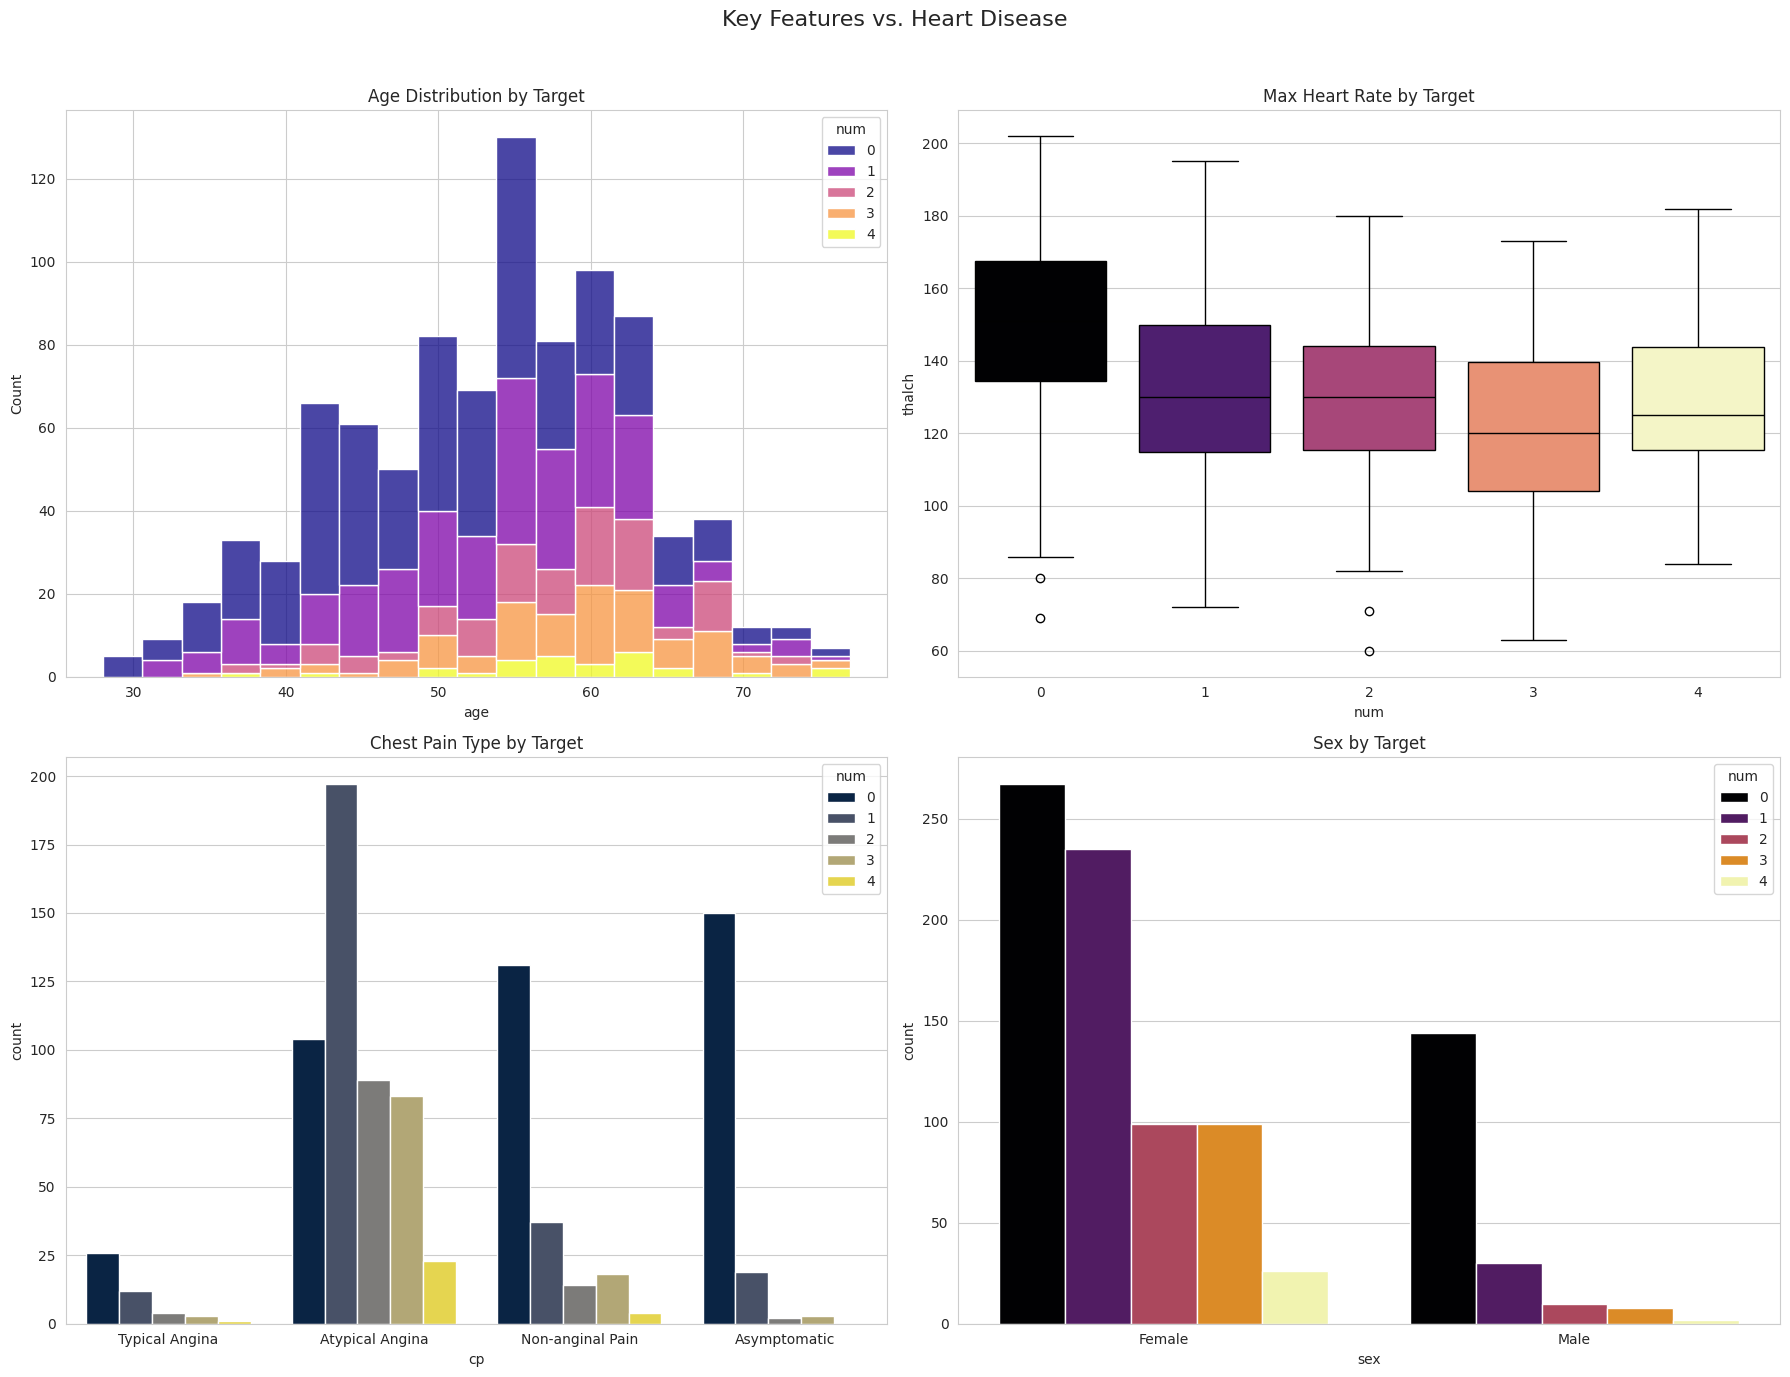

In [23]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

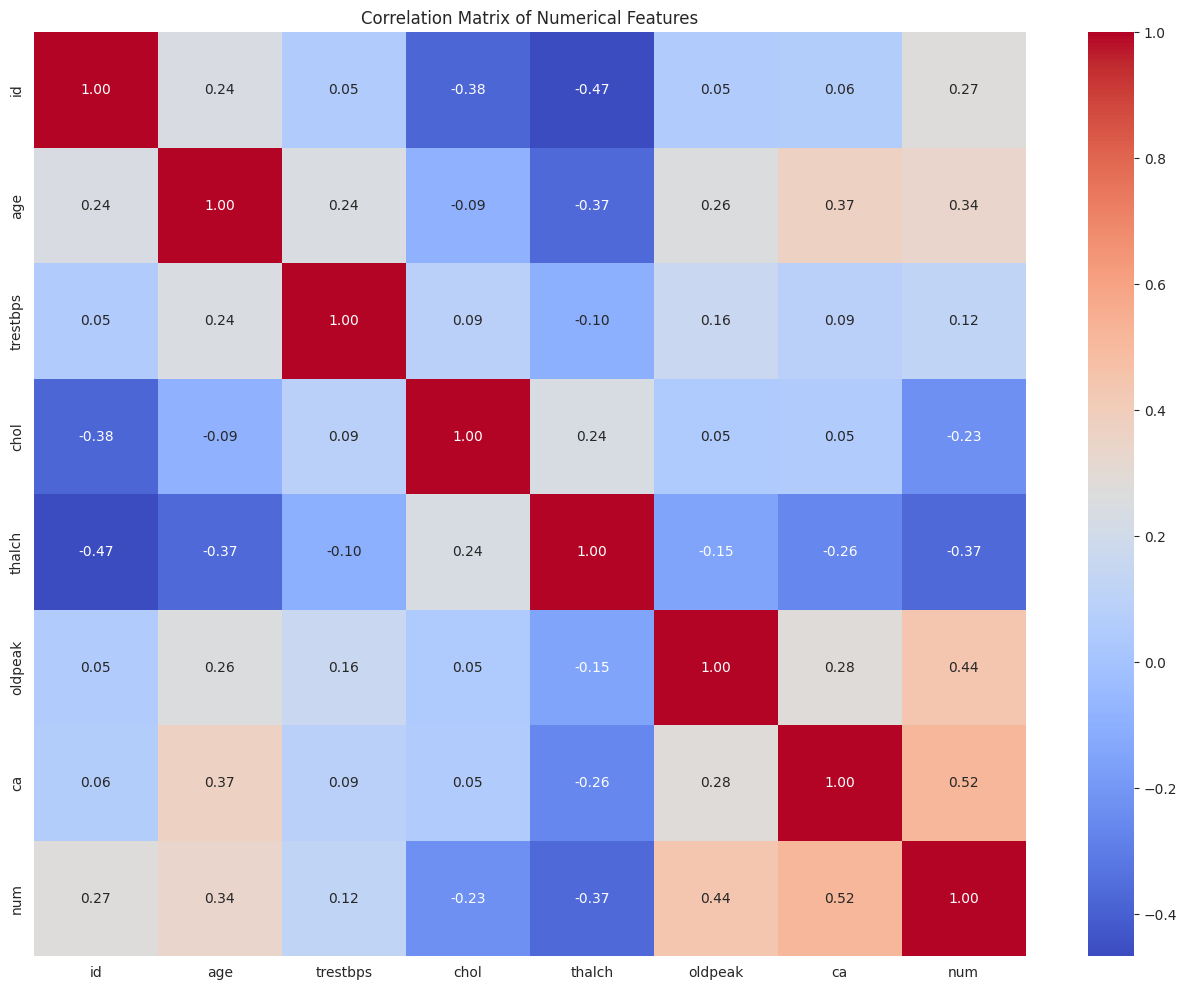

In [24]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [26]:
from sklearn.impute import SimpleImputer

# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)


# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Create preprocessing pipelines for numerical and categorical features


# Create preprocessing pipelines for numerical and categorical features


num_imputer = SimpleImputer(strategy='mean')
X_num =pd.DataFrame(num_imputer.fit_transform(X[numerical_features]), columns = numerical_features)
num_scaled = StandardScaler()
X_scaled =pd.DataFrame(num_scaled.fit_transform(X_num), columns = numerical_features)


cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame( cat_imputer.fit_transform(X[categorical_features]), columns = categorical_features)
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_Encoded = pd.DataFrame( encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(categorical_features))


# X = pd.concat([X_num, X_cat], axis=1)
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')), # Added imputation for categorical features
#     ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
# ])

# # Create a column transformer to apply different transformations to different columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)])


X_preprocessed = pd.concat([X_scaled, X_Encoded], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

#### 4.1 Model 1: Logistic Regression (Baseline)

In [27]:
all_features = X_train.columns.tolist()
categorical_features = [col for col in all_features if X_train[col].dtype == 'object']
numerical_features = [col for col in all_features if X_train[col].dtype != 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

num_imputer = SimpleImputer(strategy='mean')
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numerical_features]),
                           columns=numerical_features)

X_test_num = pd.DataFrame(num_imputer.transform(X_test[numerical_features]),
                          columns=numerical_features)

scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num),
                                  columns=numerical_features)

X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num),
                                 columns=numerical_features)

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_cat = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]),
                           columns=encoder.get_feature_names_out(categorical_features))

X_test_cat = pd.DataFrame(encoder.transform(X_test[categorical_features]),
                          columns=encoder.get_feature_names_out(categorical_features))

X_train_final = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_cat], axis=1)

model = LogisticRegression(random_state=42)
model.fit(X_train_final, y_train)

y_pred_lr = model.predict(X_test_final)

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect']
Categorical features: []


#### 4.2 Model 2: Random Forest Classifier (Advanced)

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)

y_pred_rf = rf_model.predict(X_test_final)

#### 4.3 Model 3: Support Vector Machine (SVM)

In [29]:
from sklearn.svm import SVC

svm_model = SVC(random_state=42)
svm_model.fit(X_train_final, y_train)

y_pred_svm = svm_model.predict(X_test_final)

#### 4.4 Model 4: K-Nearest Neighbors (KNN)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_final, y_train)

y_pred_knn = knn_model.predict(X_test_final)

### Step 5: Model Evaluation

In [31]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        82
           1       0.46      0.57      0.51        53
           2       0.30      0.14      0.19        22
           3       0.23      0.24      0.23        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.36      0.36      0.35       184
weighted avg       0.55      0.58      0.56       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.75      0.87      0.80        82
           1       0.56      0.57      0.56        53
           2       0.12      0.09      0.11        22
           3       0.21      0.19      0.20        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.33      0.34      0.33       184
we

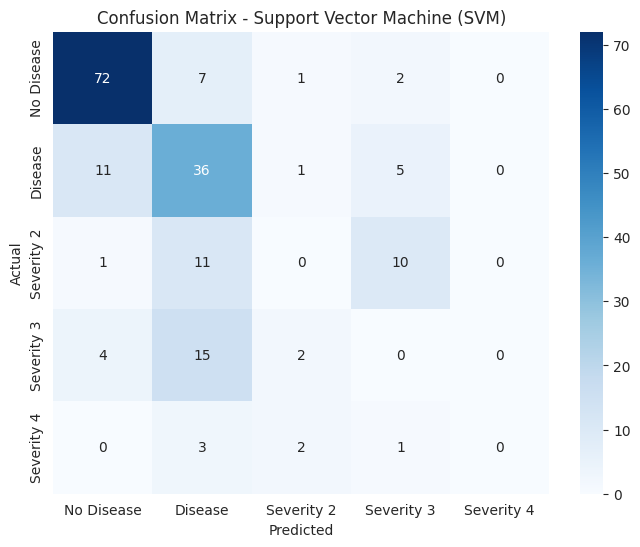

In [33]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()

### Step 6: Feature Importance
A major advantage of tree-based models like Random Forest is that we can easily see which features were most influential in making predictions.

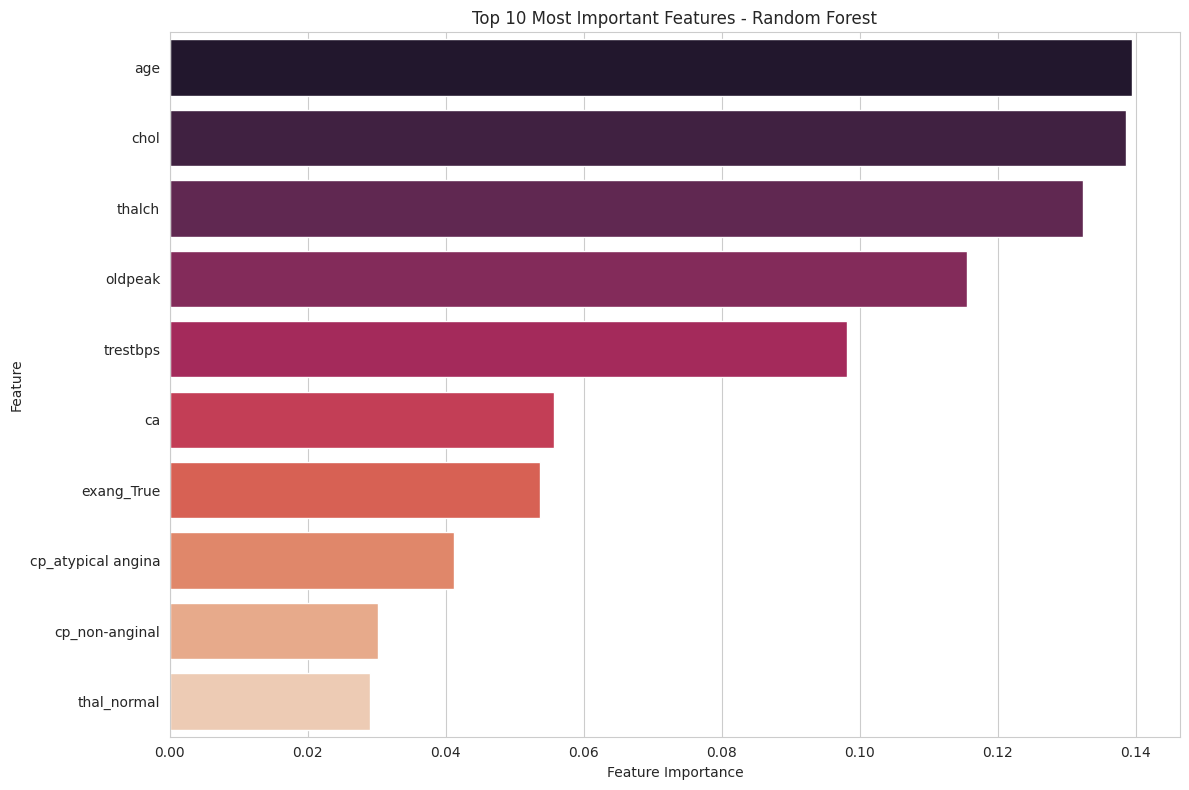

In [34]:
num_feature_names = numerical_features
cat_feature_names = encoder.get_feature_names_out(categorical_features)
feature_names = list(num_feature_names) + list(cat_feature_names)

# --- Step 2: Get feature importances from trained Random Forest model ---
importances = rf_model.feature_importances_

# --- Step 3: Create DataFrame for visualization ---
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# --- Step 4: Plot using Seaborn ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()